In [1]:
import sys
sys.path.insert(0, "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/src/")
from HNLimits import hnl_tools

['/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/src/', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python310.zip', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python3.10', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python3.10/lib-dynload', '', '/n/home09/nkamp/.local/lib/python3.10/site-packages', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python3.10/site-packages']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("figures.mplstyle")

from hepunits import g
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
from scipy.interpolate import CloughTocher2DInterpolator

from src.constants import *

m4_range = np.logspace(-3,3,1000)


In [3]:
def plot_existing_limits(case):
    for _case,limit in case.limits.iterrows():
        try:
            if limit.m4_top is not None and limit.plot_label not in ['Cosmology', "NuTeV"]:
                # Create points for convex hull
                # Combine bottom and top curves
                points = np.column_stack([limit.m4,limit.ualpha4])

                # Remove any duplicate or invalid points
                points = points[~np.isnan(points).any(axis=1)]

                if len(points) > 2:
                    # Compute convex hull
                    hull = ConvexHull(points)

                    # Create polygon from hull vertices
                    hull_points = points[hull.vertices]
                    polygon = patches.Polygon(hull_points, closed=True, alpha=1,
                                            facecolor='lightgray',edgecolor='gray')
                    plt.gca().add_patch(polygon)
            else:
                x = m4_range
                y = limit.interp_func(m4_range)
                ytop = limit.interp_func_top(m4_range)
                nan_mask = np.logical_not(np.isnan(y) | np.isnan(ytop))
                x = x[nan_mask]
                y = y[nan_mask]
                ytop = ytop[nan_mask]
                if limit.m4_top is None or np.max(np.abs(y-ytop))<1e-3:
                    ytop = 1e-2*np.ones_like(ytop)
                if limit.plot_label == "Cosmology":
                    plt.fill_between(x,y,ytop, alpha=0.2, facecolor='lightgray',edgecolor='gray',hatch='//',zorder=0)
                else:
                    plt.fill_between(x,y,ytop, alpha=1, facecolor='lightgray',edgecolor='gray')
        except Exception as e:
            print(f"Could not plot limit {limit.plot_label}: {e}")

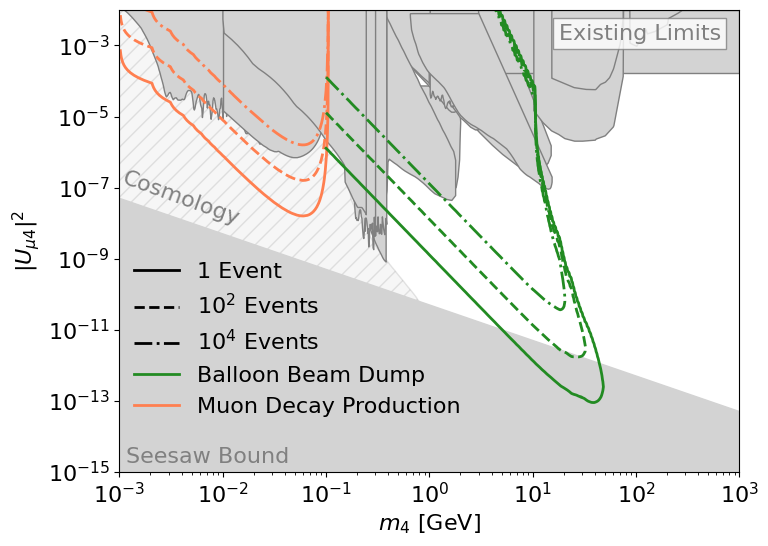

In [7]:
# muon limits

# first, plot existing limits
plt.text(0.97,0.97,"Existing Limits",color="gray",fontsize=16,
         transform=plt.gca().transAxes,ha="right",va="top",
         bbox=dict(facecolor='white',edgecolor='gray',alpha=0.8))
case_muon = hnl_tools.Limits(flavor='mu', invisible=False, nature='majorana')
plot_existing_limits(case_muon)

# now loop through existing data

# first the decay production constraints
decay_color = "coral"
for level in range(3):
    plt.plot([],[],label=f"{['1',r'$10^{2}$',r'$10^{4}$'][level]}" + " %s"%('Event' if level==0 else 'Events'),linestyle=['-','--','-.'][level],color="black")
    contour_data = np.loadtxt("data/decay_production_contours/HNL_events_muon_mixing_contour_%d.txt"%level)
    # split into segments based on NaN rows
    segments = np.split(contour_data, np.where(np.isnan(contour_data).all(axis=1))[0])
    for segment in segments:
        if segment.size == 0:
            continue
        segment = np.append(segment, np.array([[m_mu,1]]), axis=0)  # ensure last point is at the top
        plt.plot(segment[:,0], segment[:,1], linestyle=['-','--','-.'][level], color=decay_color)

# now plot the balloon sensitivity curves
balloon_color = "forestgreen"
min_photons = 10
for level in range(3):
    contour_data = np.loadtxt("data/balloon_contours/HNL_events_%d_nmin_%d.txt"%(level,min_photons))
    # split into segments based on NaN rows
    segments = np.split(contour_data, np.where(np.isnan(contour_data).all(axis=1))[0])
    for segment in segments:
        if segment.size == 0:
            continue
        segment = np.append(segment, np.array([[m_mu,1]]), axis=0)  # ensure last point is at the top
        plt.plot(segment[:,0], segment[:,1], linestyle=['-','--','-.'][level], color=balloon_color)

# seesaw bound
U2_seesaw_upper = 5e-11 / m4_range
plt.fill_between(m4_range,0,U2_seesaw_upper,color="lightgray",alpha=1)
#plt.plot(m4_range,U2_seesaw_upper,color="gray")
plt.text(0.01,0.01,"Seesaw Bound",transform=plt.gca().transAxes, fontsize=16, color="gray", va="bottom", ha="left")

# cosmology label
plt.text(m4_range[1],U2_seesaw_upper[1],r"Cosmology",color="gray",fontsize=16,
         rotation=-20,ha="left",va="center")

plt.loglog()
plt.xlim(m4_range[0], m4_range[-1])
plt.ylim(1e-15,1e-2)

plt.plot([],[],label="Balloon Beam Dump",color=balloon_color)
plt.plot([],[],label="Muon Decay Production",color=decay_color)
plt.legend(loc=[0.01,0.1])


plt.xlabel(r"$m_4$ [GeV]", fontsize=16)
plt.ylabel(r"$|U_{\mu4}|^2$", fontsize=16)
plt.show()

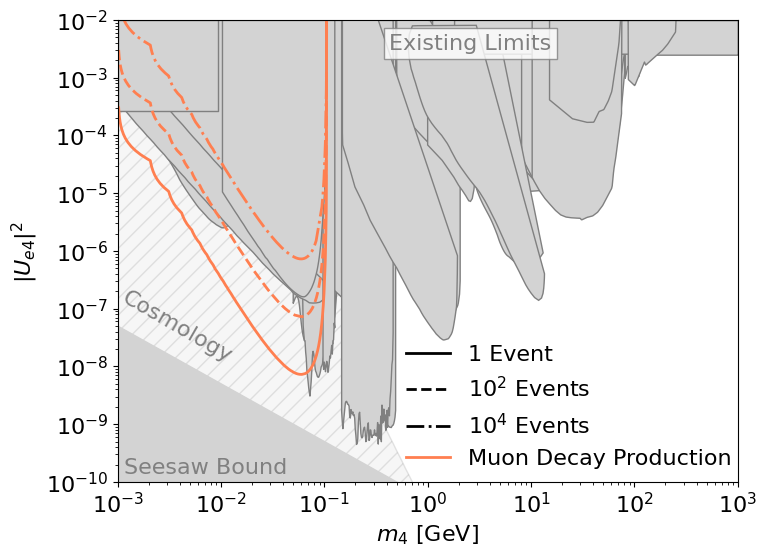

In [5]:
# electron limits

# first, plot existing limits
plt.text(0.7,0.97,"Existing Limits",color="gray",fontsize=16,
         transform=plt.gca().transAxes,ha="right",va="top",
         bbox=dict(facecolor='white',edgecolor='gray',alpha=0.8))
case_electron = hnl_tools.Limits(flavor='e', invisible=False, nature='majorana')
plot_existing_limits(case_electron)

# now loop through existing data

# first the decay production constraints
decay_color = "coral"
for level in range(3):
    plt.plot([],[],label=f"{['1',r'$10^{2}$',r'$10^{4}$'][level]}" + " %s"%('Event' if level==0 else 'Events'),linestyle=['-','--','-.'][level],color="black")
    contour_data = np.loadtxt("data/decay_production_contours/HNL_events_electron_mixing_contour_%d.txt"%level)
    # split into segments based on NaN rows
    segments = np.split(contour_data, np.where(np.isnan(contour_data).all(axis=1))[0])
    for segment in segments:
        if segment.size == 0:
            continue
        segment = np.append(segment, np.array([[m_mu,1]]), axis=0)  # ensure last point is at the top
        plt.plot(segment[:,0], segment[:,1], linestyle=['-','--','-.'][level], color=decay_color)

# seesaw bound
U2_seesaw_upper = 5e-11 / m4_range
plt.fill_between(m4_range,0,U2_seesaw_upper,color="lightgray",alpha=1)
#plt.plot(m4_range,U2_seesaw_upper,color="gray")
plt.text(0.01,0.01,"Seesaw Bound",transform=plt.gca().transAxes, fontsize=16, color="gray", va="bottom", ha="left")

# cosmology label
plt.text(m4_range[1],U2_seesaw_upper[1],r"Cosmology",color="gray",fontsize=16,
         rotation=-30,ha="left",va="center")


plt.plot([],[],label="Muon Decay Production",color=decay_color)
plt.legend(loc=[0.45,0.01])

plt.loglog()
plt.xlim(m4_range[0], m4_range[-1])
plt.ylim(1e-10,1e-2)
plt.xlabel(r"$m_4$ [GeV]", fontsize=16)
plt.ylabel(r"$|U_{e4}|^2$", fontsize=16)
plt.show()